In [ ]:
!pip install git+https://github.com/amkatrutsa/liboptpy

  Cloning https://github.com/amkatrutsa/liboptpy to c:\users\jhoma\appdata\local\temp\pip-req-build-9jzwps75
  Resolved https://github.com/amkatrutsa/liboptpy to commit a40d8839dd12edb07fb6860d1337f034a2ea4754
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for liboptpy: filename=liboptpy-0.0.1-py3-none-any.whl size=12996 sha256=2de3cb3205e363ea201b0784f38954427602d5902a6b0c06472985c336409f9c
  Stored in directory: C:\Users\jhoma\AppData\Local\Temp\pip-ephem-wheel-cache-l8bg4gdn\wheels\0f\7e\c2\62b3a5d81529c3f9b5711224a61b894b4d8cc7dfb6ea07e292
Successfully built liboptpy


  Running command git clone --filter=blob:none --quiet https://github.com/amkatrutsa/liboptpy 'C:\Users\jhoma\AppData\Local\Temp\pip-req-build-9jzwps75'


In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as ipywidg
import liboptpy.unconstr_solvers as methods
import liboptpy.step_size as ss
import cvxpy as cvx
import scipy.optimize as scopt
import seaborn as sns
import sklearn.datasets as skldata
import scipy.special as scspec
import liboptpy.restarts as restarts
import liboptpy.base_optimizer as base
import liboptpy.unconstr_solvers.fo as fo


plt.rcParams.update({
    "text.usetex": False,
    "font.family": "Helvetica"
})
sns.set_context("talk")

In [ ]:
def callback(x, array):
    array.append(x)

## Метод сопряжённых градиентов для неквадратичной функции
**Идея:** использовать градиенты $f'(x_k)$ неквадратичной функции вместо остатков $r_k$ и линейный поиск шага $\alpha_k$ вместо аналитического вычисления. Получим метод Флетчера-Ривса.

```python
def ConjugateGradientFR(f, gradf, x0):
    x = x0
    grad = gradf(x)
    p = -grad
    while np.linalg.norm(gradf(x)) != 0:
        alpha = StepSearch(x, f, gradf, **kwargs)
        x = x + alpha * p
        grad_next = gradf(x)
        beta = grad_next.dot(grad_next) / grad.dot(grad)
        p = -grad_next + beta * p
        grad = grad_next
        if restart_condition:
            p = -gradf(x)
    return x
```

### Перезапуск (restart)

1. Для ускорения метода сопряжённых градиентов используют технику перезапусков: удаление ранее накопленной истории и перезапуск метода с текущей точки, как будто это точка $x_0$
2. Существуют разные условия, сигнализирующие о том, что надо делать перезапуск, например
    - $k = n$
    - $\dfrac{|\langle f'(x_k), f'(x_{k-1}) \rangle |}{\| f'(x_k) \|_2^2} \geq \nu \approx 0.1$
3. Можно показать (см. Nocedal, Wright Numerical Optimization, Ch. 5, p. 125), что запуск метода Флетчера-Ривза без использования перезапусков на некоторых итерациях может приводить к крайне медленной сходимости!
4. Метод Полака-Рибьера и его модификации лишены подобного недостатка.

In [ ]:
def ConjugateGradientFR(f, gradf, x0, num_iter=100, tol=1e-8, callback=None, restart=False):
    x = x0
    grad = gradf(x)
    p = -grad
    it = 0
    while np.linalg.norm(gradf(x)) > tol and it < num_iter:
        alpha = utils.backtracking(x, p, method="Wolfe", beta1=0.1, beta2=0.4, rho=0.5, f=f, grad_f=gradf)
        if alpha < 1e-18:
            break
        x = x + alpha * p
        if callback is not None:
            callback(x)
        grad_next = gradf(x)
        beta = grad_next.dot(grad_next) / grad.dot(grad)
        p = -grad_next + beta * p
        grad = grad_next.copy()
        it += 1
        if restart and it % restart == 0:
            grad = gradf(x)
            p = -grad
    return x

In [ ]:
n = 300
m = 1000

X, y = skldata.make_classification(n_classes=2, n_features=n, n_samples=m, n_informative=n//3)
C = 1
def f(w):
    return np.linalg.norm(w)**2 / 2 +  C * np.mean(np.logaddexp(np.zeros(X.shape[0]), -y * X.dot(w)))

def grad_f(w):
    denom = scspec.expit(-y * X.dot(w))
    return w - C * X.T.dot(y * denom) / X.shape[0]
# f = lambda x: -np.sum(np.log(1 - A.T.dot(x))) - np.sum(np.log(1 - x*x))
# grad_f = lambda x: np.sum(A.dot(np.diagflat(1 / (1 - A.T.dot(x)))), axis=1) + 2 * x / (1 - np.power(x, 2))
x0 = np.zeros(n)
print("Initial function value = {}".format(f(x0)))
print("Initial gradient norm = {}".format(np.linalg.norm(grad_f(x0))))

Initial function value = 0.6931471805599454
Initial gradient norm = 2.222630188421962


In [ ]:
n_restart = 100
tol = 1e-5
max_iter = 600

scopt_cg_array = []
scopt_cg_callback = lambda x: callback(x, scopt_cg_array)
x = scopt.minimize(f, x0, tol=tol, method="CG", jac=grad_f, callback=scopt_cg_callback, options={"maxiter": max_iter})
x = x.x
print("\t CG by Polak-Rebiere")
print("Norm of garient = {}".format(np.linalg.norm(grad_f(x))))
print("Function value = {}".format(f(x)))

print("\t CG by Fletcher-Reeves")
cg_fr = methods.fo.ConjugateGradientFR(f, grad_f, ss.Backtracking("Wolfe", rho=0.5, beta1=0.01, beta2=0.9, init_alpha=1.))
x = cg_fr.solve(x0, tol=tol, max_iter=max_iter, disp=True)

print("\t CG by Fletcher-Reeves with restart n")
cg_fr_rest = methods.fo.ConjugateGradientFR(f, grad_f, ss.Backtracking("Wolfe", rho=0.5, beta1=0.01, beta2=0.9,
                                         init_alpha=1.), restarts.Restart(n // n_restart))
x = cg_fr_rest.solve(x0, tol=tol, max_iter=max_iter, disp=True)

print("\t Gradient Descent")
gd = methods.fo.GradientDescent(f, grad_f, ss.Backtracking("Wolfe", rho=0.5, beta1=0.01, beta2=0.9, init_alpha=1.))
x = gd.solve(x0, max_iter=max_iter, tol=tol, disp=True)

	 CG by Polak-Rebiere
Norm of garient = 2.3961691841901727e-05
Function value = 0.48255695995290465
	 CG by Fletcher-Reeves
Required tolerance achieved!
Convergence in 377 iterations
Function value = 0.4825569598782634
Norm of gradient = 9.819863951818776e-06
	 CG by Fletcher-Reeves with restart n
Required tolerance achieved!
Convergence in 54 iterations
Function value = 0.4825569598766414
Norm of gradient = 9.682719143992567e-06
	 Gradient Descent
Required tolerance achieved!
Convergence in 276 iterations
Function value = 0.4825569599010743
Norm of gradient = 9.466453054795698e-06


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


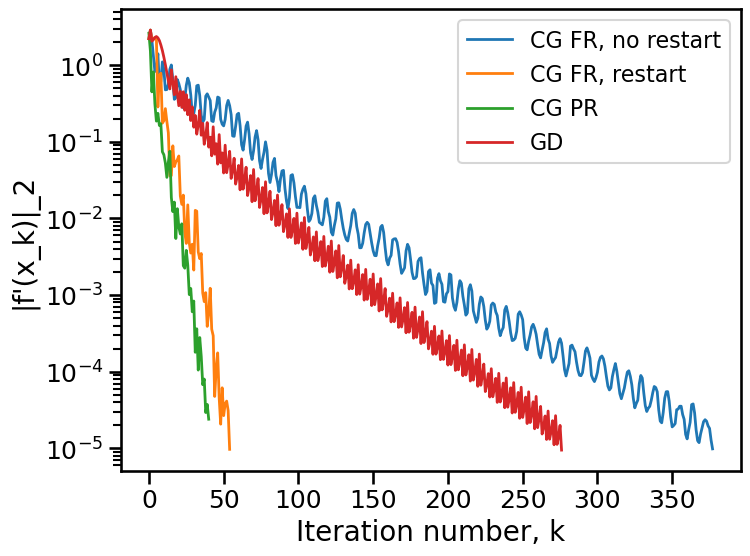

In [ ]:
plt.figure(figsize=(8, 6))
plt.semilogy([np.linalg.norm(grad_f(x)) for x in cg_fr.get_convergence()], label="CG FR, no restart", linewidth=2)
plt.semilogy([np.linalg.norm(grad_f(x)) for x in cg_fr_rest.get_convergence()], label=r"CG FR, restart", linewidth=2)
plt.semilogy([np.linalg.norm(grad_f(x)) for x in scopt_cg_array], label="CG PR", linewidth=2)

plt.semilogy([np.linalg.norm(grad_f(x)) for x in gd.get_convergence()], label="GD", linewidth=2)
plt.legend(loc="best", fontsize=16)
plt.xlabel("Iteration number, k", fontsize=20)
plt.ylabel("|f'(x_k)|_2", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

## Квазиньютоновские методы: между двух огней

## Сравнительный анализ метода Ньютона и градиентного спуска

Метод | Скорость сходимости | Сложность | Аффинная инвариантность | Требования к $f(x)$
:---: | :---: | :---: | :---: | :---:
Градиентный спуск | Глобально линейная | $O(n) + $ определение шага | Нет | Дифференцируема; градиент липшицев
Метод Ньютона | Локально квадратичная | $O(n^3) + $ определение шага | Да | Дважды диференцируема; гессиан липшицев, положительно определён

## Как уменьшить сложность хранения и вычисления?

- Сложность вычисления можно уменьшить с помощью
    - Квазиньютоновские методы, они же методы переменной метрики
    - Требуется хранение матрицы $n \times n$
    
- Сложность вычисления и хранения можно уменьшить
    - квазиньютоновские методы с ограниченной памятью, например [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) (Limited Memory Broyden-Fletcher-Goldfarb-Shanno)
    - НЕ требуется хранить матрицу
    - вместо этого хранятся $k \ll n$ векторов из $\mathbb{R}^n$

## Единообразный способ получения метода Ньютона и градиентного спуска

- градиентный метод получен из аппроксимации первого порядка:

$$
f_G(x) \approx f(y) + \langle f'(y), x - y \rangle + \frac{1}{2}(x-y)^{\top} \frac{1}{\alpha}I(x - y)
$$

причём при $\alpha \in (0, 1/L], f(x) \leq f_G(x)$, то есть $f_G$ - глобальная оценка $f(x)$
- метод Ньютона получен из аппроксимации второго порядка

$$
f_N(x) \approx f(y) + \langle f'(y), x - y \rangle + \frac{1}{2} (x-y)^{\top}f''(y)(x-y)
$$

**Идея:** использовать промежуточную аппроксимацию вида

$$
f_q(x) \approx f(y) + \langle f'(y), x - y \rangle + \frac{1}{2} (x-y)^{\top}{\color{red}{B(y)}}(x-y),
$$

которая даёт переход к следующей точке:

$$
x_{k+1} = x_k - \alpha_k B^{-1}_k f'(x_k) = x_k - \alpha_k H_k f'(x_k)
$$

## Немного истории...
- Первый квазиньютоновский метод придумал физик William Davidon в середине 1950-х для ускорения своих вычислений на ненадёжных компьютерах
- Его статью с описанием предложенного метода не приняли к публикации, и она оставалась техническим отчётом <br></br> более 30 лет
- [Опубликована](http://epubs.siam.org/doi/abs/10.1137/0801001) в 1991 году в первом выпуске [SIAM Journal on Optimization](https://www.siam.org/journals/siopt.php)

## Общая схема квазиньютоновских методов

```python
def QuasiNewtonMethod(f, x0, epsilon, **kwargs):
    
    x = x0
    
    H = I
    
    while True:
        
        h = -H.dot(grad_f(x))
        
        if StopCriterion(x, f, h, **kwargs) < epsilon:
            
            break
            
        alpha = SelectStepSize(x, h, f, **kwargs)
            
        x = x + alpha * h
            
        H = UpdateH(H, f(x), grad_f(x))
            
    return x
```

## Как искать $B_{k+1}$?

В точке $x_{k+1}$ имеем следующую аппрокисмацию:

$$
f_q(h) \approx f(x_{k+1}) + \langle f'(x_{k+1}), h \rangle + \frac{1}{2}h^{\top}B_{k+1}h
$$

Из определения, очевидно, что $B_{k+1} \in \mathbb{S}^n_{++}$.
Какие требования естественно наложить на $f_q(h)$?

$$
f_q'(-\alpha_k h_k) = f'(x_k) \qquad f'_q(0) = f'(x_{k+1}),
$$

где первое условие даёт

$$
f'(x_{k+1}) - \alpha_k B_{k+1}h_k = f'(x_k),
$$

а второе выполняется автоматически.

### Квазиньютоновское уравнение (Secant equation)

Из первого условия получаем

$$
B_{k+1}s_k = y_k,
$$

где $s_k = x_{k+1} - x_k$ и $y_k = f'(x_{k+1}) - f'(x_k)$.

Это уравнение будет иметь решение только при $s^{\top}_k y_k > 0$.

### Как однозначно определить $B_{k+1}$?

\begin{align*}
& \min_B \| B_k - B \| \\
\text{s.t. } & B = B^{\top}\\
& Bs_k = y_k
\end{align*}

## DFP (Davidon-Fletcher-Powell)

$$
B_{k+1} = (I - \rho_k y_k s^{\top}_k)B_k(I - \rho_k s_ky^{\top}_k) + \rho_k y_k y^{\top}_k,
$$

где $\rho_k = \dfrac{1}{y^{\top}_k s_k}$,

или с помощью формулы Шермана-Морисона-Вудбери

$$
B^{-1}_{k+1} = H_{k+1} = H_k - \dfrac{H_ky_k y_k^{\top}H_k}{y^{\top}_kH_ky_k} + \dfrac{s_ks^{\top}_k}{y^{\top}_ks_k}
$$

### Вывод

Общая идея квазиньютоновских методов:

вместо полного пересчёта гессиана на каждой итерации обновлять

текущую его аппроксимацию с помощью легко вычислимого

преобразования

## BFGS

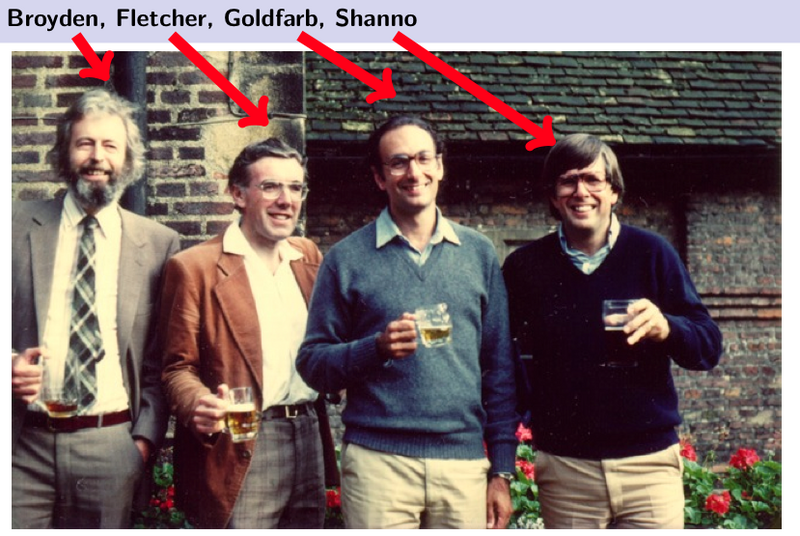

**Вопрос:** какая естественная модификация метода DFP?

\begin{align*}
& \min_H \| H_k - H \| \\
\text{s.t. } & H = H^{\top}\\
& Hy_k = s_k
\end{align*}

Формула пересчёта для метода BFGS:

$$
H_{k+1} = (I - \rho_k s_ky^{\top}_k)H_k(I - \rho_k y_k s^{\top}_k) + \rho_k s_k s^{\top}_k,
$$

где $\rho_k = \dfrac{1}{y^{\top}_k s_k}$

### Детали реализации

- Не должно быть операций сложностью $O(n^3)$, то есть никаких матричных умножений и решений линейных систем (cf. [реализацию в SciPy](https://github.com/scipy/scipy/blob/v0.18.1/scipy/optimize/optimize.py#L874-L976))
- Только правило Вольфа гарантирует соблюдения условия кривизны $y_k^{\top}s_k > 0$
- Параметры в правиле Вольфа обычно следующие
    - $\alpha_0 = 1$ необходим для сверхлинейной скорости
    - $\beta_1 = 10^{-4}$, $\beta_2 = 0.9$
- Способы инициализации $H_0$
    - единичная матрица
    - $H_0 = \frac{y_0^{\top}s_0}{y_0^{\top}y_0}I$ **после** первого шага, но до вычисления $H_1$.При вычислении $x_1$  используется $H_0 = I$
    - $H_0 = \delta \|g_0\|^{-1}_2 I$, параметр $\delta$ необходимо заранее задать
- При использовании $B$ вместо $H$ нужно хранить $B$ в виде $LDL^{\top}$ разложения и обновлять не саму матрицу $B$, а её разложение. Это явно делается за $O(n^2)$. Вычисление $h_k$ - это решение линейной системы с предвычисленным раздложением матрицы, следовательно сложность также $O(n^2)$. Этот подход позволяет контролировать устройчивость в диагонали матрицы $D$. На практике предпочтительнее работать с матрицей $H$


### Сходимость

**Теорема**

Пусть $f$ дважды непрерывно дифференцируема и её гессиан липшицев, также пусть последовательность генерируемая методом BFGS сходится к точке $x^*$ так что $\sum_{k=1}^{\infty} \|x_k - x^*\| < \infty$. Тогда $x_k \to x^*$ сверхлинейно.

**Цикл работ по квазиньютоновским метдом с анализом явно выраженной неасимптотической скоростью сходимости**

[Greedy Quasi-Newton Methods with Explicit Superlinear Convergence](https://arxiv.org/abs/2002.00657)

[New Results on Superlinear Convergence of Classical Quasi-Newton Methods](https://link.springer.com/article/10.1007/s10957-020-01805-8)

[Rates of superlinear convergence for classical quasi-Newton methods](https://link.springer.com/article/10.1007/s10107-021-01622-5)

### Самокоррекция

- Если BFGS на некоторой итерации даёт плохую оценку обратного гессиана, то через несколько итераций это недоразумение будет **автоматически** исправлено, то есть метод сам скорректирует грубую оценку гессиана
- Это свойство появляется только при правильном способе выбора шага, например при использовании правила Вольфа
- Метод DFP существенно хуже корректирует неточные оценки обратного гессиана
- Всё это будет ниже проиллюстрировано на примерах

## BFGS с ограниченной памятью (L-BFGS)

- В методе BFGS нужна не сама матрица $H$, а только функция умножения её на вектор
- Поскольку требуется локальная оценка гессиана, старые значения векторов $s$ и $y$ могут портить текущую оценку

**Идея**

- Хранить $k \ll n$ последних векторов $s$ и $y$ - снижение требуемой памяти с $n^2$ до $kn$
- Выполнение умножения на вектор рекурсивно, без явного формирования матрицы $H$

## Barzilai-Borwein method

- Первая [статья](http://pages.cs.wisc.edu/~swright/726/handouts/barzilai-borwein.pdf) об этом методе опубликована в 1988, в журнале IMA Journal of Numerical Analysis
- [Статья](http://papers.nips.cc/paper/6286-barzilai-borwein-step-size-for-stochastic-gradient-descent.pdf) на NIPS 2016 о модификации этого метода в случае использования стохастической оценки градиента
- Идея: комбинация идеи наискорейшего спуска и квазиньютоновского метода

### Идея метода

- Наискорейший спуск: $x_{k+1} = x_k - \alpha_k f'(x_k)$, $\alpha_k = \arg \min\limits_{\alpha > 0} f(x_{k+1})$
- Метод Ньютона: $x_{k+1} = x_k - (f''(x_k))^{-1} f'(x_k)$
- Аппроксимация гессиана диагональной матрицей:

$$
\alpha_k f'(x_k) = \alpha_k I f'(x_k) = \left( \frac{1}{\alpha_k} I \right)^{-1} f'(x_k) \approx (f''(x_k))^{-1} f'(x_k)
$$

- Как найти $\alpha_k$?

### Снова квазиньютоновское уравнение (Secant equation)
- Для точного гессиана
$$
f''(x_{k})(x_{k} - x_{k-1}) = f'(x_{k}) - f'(x_{k-1})
$$
- Для приближения

$$
\alpha_k^{-1} s_{k-1} \approx y_{k-1}
$$

- Задача аппроксимации одного вектора с помощью масштабирования другого
- Простейший квазиньютоновский метод вырождается в поиск оптимального шага

### Три способа найти $\alpha_k$

- Первый способ
    - Задача
    
    $$
    \min_{\beta} \|\beta s_{k-1} - y_{k-1} \|^2_2
    $$
    
    - Решение
    
    $\alpha = \frac{1}{\beta} = \frac{s^{\top}_{k-1} s_{k-1}}{s^{\top}_{k-1} y_{k-1}}$
    
- Второй способ
    - Задача
    
    $$
    \min_{\alpha} \| s_{k-1} - \alpha y_{k-1} \|^2_2
    $$
    
    - Решение
    
    $$
    \alpha = \frac{s^{\top}_{k-1} y_{k-1}}{y^{\top}_{k-1} y_{k-1}}
    $$
- Третий способ называется немонотонный линейный поиск: специальная модификация правил Армихо, учитывающая историю изменений значения функции, [статья](https://www.math.lsu.edu/~hozhang/papers/nonmonotone.pdf) 2004 г. в SIAM Journal on Optimization

## Эксперименты

### Поиск аналитического центра системы неравенств

$$
f(x) = - \sum_{i=1}^m \log(1 - a_i^{\top}x) - \sum\limits_{i = 1}^n \log (1 - x^2_i) \to \min_x
$$

In [ ]:
n = 3000
m = 100
x0 = np.zeros(n)
max_iter = 100
tol = 1e-5
A = np.random.rand(m, n) * 10
EPS = 1e-10

In [ ]:
f = lambda x: -np.sum(np.log(np.maximum(1 - A.dot(x), EPS))) - np.sum(np.log(np.maximum(1 - x*x, EPS)))
grad_f = lambda x: np.sum(A.T / (1 - A.dot(x)), axis=1) + 2 * x / (1 - np.power(x, 2))

In [ ]:
def bb_method(f, gradf, x0, tol=1e-6, maxiter=100, callback=None, alpha_type=1):
    it = 0
    x_prev = x0.copy()
    current_tol = np.linalg.norm(gradf(x_prev))
    alpha = 1e-4
    while current_tol > tol and it < maxiter:
        it += 1
        current_grad = gradf(x_prev)
        if it != 1:
            g = current_grad - prev_grad
            if alpha_type == 1:
                alpha = g.dot(s) / g.dot(g)
            elif alpha_type == 2:
                alpha = s.dot(s) / g.dot(s)
        if callback:
            callback(x_prev)
        x_next = x_prev - alpha * current_grad
        current_tol = np.linalg.norm(gradf(x_next))
        prev_grad = current_grad
        s = x_next - x_prev
        x_prev = x_next
    if callback:
        callback(x_prev)
    return x_next

In [ ]:
method = {
    "BB 1": methods.fo.BarzilaiBorweinMethod(f, grad_f, init_alpha=1e-4, type=1),
    "BFGS": methods.fo.BFGS(f, grad_f),
    "DFP": methods.fo.DFP(f, grad_f),
    "LBFGS": methods.fo.LBFGS(f, grad_f),
}

In [ ]:
for m in method:
    print("\t Method {}".format(m))
    _ = method[m].solve(x0=x0, tol=tol, max_iter=max_iter, disp=True)

print("\t Method BFGS Scipy")
scopt_conv = []
scopt_res = scopt.minimize(f, x0, method="BFGS", jac=grad_f, callback=lambda x: scopt_conv.append(x),
                           tol=tol, options={"maxiter": max_iter})
print("Result: {}".format(scopt_res.message))
if scopt_res.success:
    print("Convergence in {} iterations".format(scopt_res.nit))
print("Function value = {}".format(f(scopt_res.x)))

	 Method BB 1
Required tolerance achieved!
Convergence in 10 iterations
Function value = -706.6538816576468
Norm of gradient = 5.0615600669686835e-06
	 Method BFGS
Required tolerance achieved!
Convergence in 24 iterations
Function value = -706.6538816576394
Norm of gradient = 6.713517075060981e-06
	 Method DFP
Maximum iteration exceeds!
Convergence in 100 iterations
Function value = -706.6536450978899
Norm of gradient = 0.03206062554159491
	 Method LBFGS
Required tolerance achieved!
Convergence in 14 iterations
Function value = -706.6538816576494
Norm of gradient = 1.4776666430050967e-06
	 Method BFGS Scipy
Result: Optimization terminated successfully.
Convergence in 17 iterations
Function value = -706.6538816575395


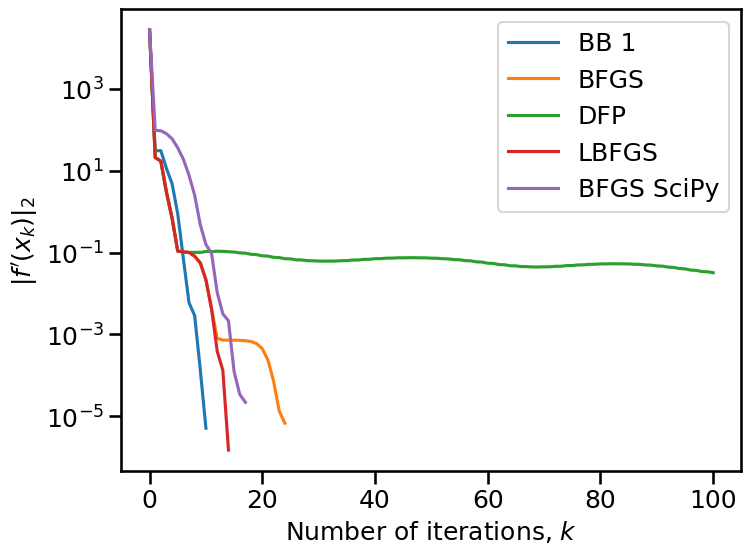

In [ ]:
plt.figure(figsize=(8, 6))

for m in method:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in method[m].get_convergence()], label=m)

plt.semilogy([np.linalg.norm(grad_f(x)) for x in [x0] + scopt_conv], label="BFGS SciPy")
plt.ylabel("$\|f'(x_k)\|_2$", fontsize=18)
plt.xlabel("Number of iterations, $k$", fontsize=18)
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.show()

### Плохо обусловленная задача

In [ ]:
n = 50
D = np.arange(1, n+1)
U = np.random.randn(n, n)
U, _ = np.linalg.qr(U)
A = U.dot(np.diag(D)).dot(U.T)
b = np.random.randn(n)
eig_vals = np.linalg.eigvals(A)
print("Condition number = {}".format(np.max(eig_vals) / np.min(eig_vals)))

Condition number = 50.00000000000108


In [ ]:
f = lambda x: 0.5 * x.T.dot(A.dot(x)) - b.dot(x)
gradf = lambda x: A.dot(x) - b
x0 = np.random.randn(n)

In [ ]:
method = {
    "BB 1": methods.fo.BarzilaiBorweinMethod(f, gradf, init_alpha=1e-4, type=1),
    "BB 2": methods.fo.BarzilaiBorweinMethod(f, gradf, init_alpha=1e-4, type=2),
    "BFGS": methods.fo.BFGS(f, gradf),
    "DFP": methods.fo.DFP(f, gradf),
    "GD": methods.fo.GradientDescent(f, gradf, ss.ExactLineSearch4Quad(A, b)),
    "LBFGS": methods.fo.LBFGS(f, gradf, hist_size=10),
}

In [ ]:
for m in method:
    print("\t Method {}".format(m))
    _ = method[m].solve(x0=x0, tol=tol, max_iter=max_iter, disp=True)

print("\t Method BFGS Scipy")

scopt_conv = []
scopt_res = scopt.minimize(f, x0, method="BFGS", jac=gradf, callback=lambda x: scopt_conv.append(x),
                           tol=tol, options={"maxiter": max_iter})
print("Result: {}".format(scopt_res.message))
if scopt_res.success:
    print("Convergence in {} iterations".format(scopt_res.nit))
print("Function value = {}".format(f(scopt_res.x)))

	 Method BB 1
Required tolerance achieved!
Convergence in 74 iterations
Function value = -2.585465463033022
Norm of gradient = 6.026121933192181e-06
	 Method BB 2
Required tolerance achieved!
Convergence in 63 iterations
Function value = -2.585465463023234
Norm of gradient = 8.541824299962496e-06
	 Method BFGS
Required tolerance achieved!
Convergence in 47 iterations
Function value = -2.5854654630370018
Norm of gradient = 6.425970227716834e-06
	 Method DFP
Required tolerance achieved!
Convergence in 97 iterations
Function value = -2.585465463033496
Norm of gradient = 9.866125450423092e-06
	 Method GD
Maximum iteration exceeds!
Convergence in 100 iterations
Function value = -2.5848108803034777
Norm of gradient = 0.052857006729301145
	 Method LBFGS
Required tolerance achieved!
Convergence in 48 iterations
Function value = -2.585465463036163
Norm of gradient = 5.998463326105138e-06
	 Method BFGS Scipy
Result: Optimization terminated successfully.
Convergence in 59 iterations
Function valu

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


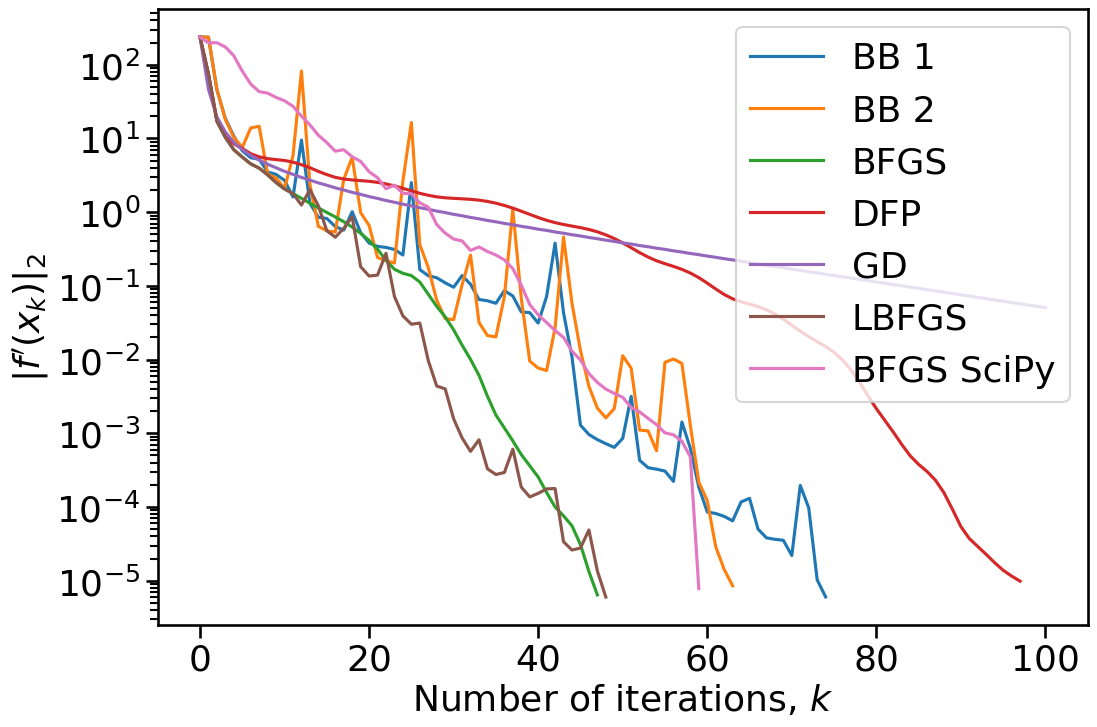

In [ ]:
plt.figure(figsize=(12, 8))
fontsize = 26
for m in method:
    plt.semilogy([np.linalg.norm(gradf(x)) for x in method[m].get_convergence()], label=m)

plt.semilogy([np.linalg.norm(gradf(x)) for x in [x0] + scopt_conv], label='BFGS SciPy')
plt.legend(fontsize=fontsize)
plt.ylabel("$\|f'(x_k)\|_2$", fontsize=fontsize)
plt.xlabel("Number of iterations, $k$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.show()

### Особенности квазиньютоновских методов

Достоинства:
1. Вместо **точного** вычисления гессиана используется его **оценка**, полученная с помощью градиента и оценки гессиана в предыдущей точке
2. Вместо решения систем линейных уравнений используется текущаю информация о функции и градиенте для аналитического вычисления приближения обращённого гессиана
3. Сложность одной итерации $O(n^2) + ...$ по сравнению с $O(n^3) + ...$ в методе Ньютона
4. Для метода L-BFGS требуется линейное количество памяти по размерности задачи
5. Свойство самокоррекции метода BFGS: если на некоторой итерации обратный гессиан оценен очень грубо, то следующие несколько итераций улучшат оценку
6. Сверхлинейная сходимость к решению задачи минимизации $f$ (подробнее см. [[1]](http://www.bioinfo.org.cn/~wangchao/maa/Numerical_Optimization.pdf))

Недостатки:
1. Нет универсального рецепта выбора начального приближения $B_0$ или $H_0$
2. Не любое условие на линейный поиск шага гарантирует выполнения условия кривизны $y^{\top}_ks_k > 0$